In [1]:
# Feel free to import anything you need

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm

from torchvision.models import resnet18
from torch.optim.lr_scheduler import StepLR

In [2]:
###########  Do not modify this cell ###########################
# ===============================================================

### seed everything for reproducibility
def seed_everything():
    seed = 24789
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 1. Contrastive learning loss functions

## 1(a) Implement the normalized temperature-scaled cross entropy loss (NT-Xent) based on SimCLR:
https://arxiv.org/pdf/2002.05709.pdf

\begin{equation}
\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_j\right) / \tau\right)}{\sum_{k=1}^{2 N}  \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_k\right) / \tau\right)}
\end{equation}

In [3]:
def nt_xent(x, t=0.5):
    """
    1. Normalize across the second dimension
    2. Compute the normalized cosine similarity scores between x and its transpose
    3. Scale the normalized cosine similarity scores x_scores by dividing them by a temperature

    """
    # 1. Normalize across the second dimension
    x = F.normalize(x, p=2, dim=1)

    # 2. Compute the normalized cosine similarity scores between x and its transpose and scale the with temperature

    x_scores = torch.matmul(x, x.t()).to(x.device)
    x_scale = x_scores/t


    # Subtract a diagonal matrix with large negative values from x_scale to set the diagonals to be zeros after softmax.
    x_scale = x_scale - torch.eye(x_scale.size(0)).to(x_scale.device) * 1e5

    # targets 2N elements.
    targets = torch.arange(x.size()[0]).to(x.device)
    targets[::2] += 1  # target of 2k element is 2k+1
    targets[1::2] -= 1  # target of 2k+1 element is 2k

    # 3 . Compute the cross entropy loss between x_scale and target and return the computed loss
    loss = torch.nn.CrossEntropyLoss()(x_scale, targets)

    return loss

In [4]:
seed_everything()

z = torch.randn(4,3)
t = 0.7

loss = nt_xent(z, t)

print("z: \n", z)
print("Loss: \n", loss)

z: 
 tensor([[-0.2997, -0.6194, -0.4414],
        [-1.2945, -0.1358, -0.2589],
        [-0.7526,  0.4345, -0.9680],
        [ 0.8034, -2.5620,  0.9044]])
Loss: 
 tensor(1.6224)


## 1 (b) Implement Barlow twins loss function
https://arxiv.org/pdf/2103.03230.pdf


Cross correlation matrix
\begin{equation}
\mathcal{C}_{i j} \triangleq \frac{\sum_b z_{b, i}^A z_{b, j}^B}{\sqrt{\sum_b\left(z_{b, i}^A\right)^2} \sqrt{\sum_b\left(z_{b, j}^B\right)^2}}
\end{equation}
Barlow Twins loss

\begin{equation}
\mathcal{L}_{\mathcal{B} \mathcal{T}} \triangleq \sum_i\left(1-\mathcal{C}_{i i}\right)^2+\lambda \quad \sum_i \sum_{j \neq i} \mathcal{C}_{i j}^2
\end{equation}

In [5]:
def off_diag_elems(x):
    """
    Compute the flattened view of the off-diagonal elements of a matrix

    """
    #FILLIN
    n = x.size(0)
    indices = torch.triu_indices(n,n,offset=1)

    return x[indices[0],indices[1]]

def barlow_twins(z1, z2, lamda, batch_size):
    """
    z1 and z2 are the output image representations
    1. Normalize the representations across the batch dimension (dim=0)
    2. Compute the cross correlation matrix (given in the equation above)
    3. Compute the barlow twins loss by following the equations given above

    """
    #FILLIN
    z1_norm = F.normalize(z1, dim=0)
    z2_norm = F.normalize(z2, dim=0)

    cross_corr_matrix = torch.mm(z1_norm.t(), z2_norm) / batch_size

    off_diag = off_diag_elems(cross_corr_matrix)

    loss = (1 - torch.diagonal(cross_corr_matrix).pow(2)).sum() + lamda * off_diag.pow(2).sum()

    return loss

In [6]:
seed_everything()

N = 4
z1 = torch.randn(N, 4)
z2 = torch.randn(N, 4)
lamda = 5e-3

loss = barlow_twins(z1, z2, lamda, N)

print("z1: \n", z1)
print("z2: \n", z2)
print("Loss: \n", loss)

z1: 
 tensor([[-0.6637, -2.2035, -0.5497,  0.1591],
        [-0.8427, -0.3029, -1.2701, -0.8752],
        [ 0.1743, -0.6272, -0.5871, -1.7928],
        [-1.7089,  0.2134, -0.3203, -0.3736]])
z2: 
 tensor([[ 0.6968,  1.8388, -0.9387, -0.4800],
        [-1.4524,  1.3257,  0.9204, -0.5180],
        [-1.0516, -0.5895,  0.5390,  0.0944],
        [-1.7974,  0.0804,  0.7257,  0.9933]])
Loss: 
 tensor(3.9208)


# 2. Implement the SimCLR model

In [7]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim):
        super().__init__()
        self.enc = base_encoder
        self.feature_dim = self.enc.fc.in_features

        # Modifying the base encoder as mentioned in B4 of SimCLR
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):

        ######## Define the forward function ############################

        feature = self.enc(x)

        projection = self.projector(feature)

        return feature, projection


In [8]:
###########  Do not modify this cell ###########################
# ===============================================================

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


Creating pairs of image on the training set

In [9]:
###########  Do not modify this cell ###########################
# ===============================================================

class CIFAR10Pair(CIFAR10):
    """Generate mini-batche pairs on CIFAR10 training set."""
    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]
        img = Image.fromarray(img)
        imgs = [self.transform(img), self.transform(img)]
        return torch.stack(imgs), target  # stack a positive pair

#3. Define the transformations, dataloaders, model, optimizer, scheduler and parameters required for training

In [15]:
############ Define the parameters for training ##############

batch_size = 128
projection_dim = 128
learning_rate =  0.001
momentum = 0.9
weight_decay = 0.0001
epochs = 50


In [12]:
assert torch.cuda.is_available()
cudnn.benchmark = True

######### Define the transformation on the training set
### Refer to the paper to understand which transformations to use ######

train_transform = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4, padding_mode='reflect'),
    transforms.Resize(size=32),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor()])

##### get absolute path of data dir

data_dir = "/content"


########## Define the train set and train dataloader and shuffle the train set

train_set = CIFAR10Pair(root=data_dir,
                        train=True,
                        transform=train_transform,
                        download=True)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True)


######## Define the base encoder(resnet18) -- load from torchvision.models without pretraining

base_encoder = resnet18(pretrained=False)
model = SimCLR(base_encoder, projection_dim).cuda()
model = model.cuda()

########### Define the optimizer and scheduler for training #######################

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


100%|██████████| 170498071/170498071 [00:12<00:00, 13135028.89it/s]


Extracting /content/cifar-10-python.tar.gz to /content


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
def train(args) -> None:
    # SimCLR training
    model.train()
    best_loss = np.inf
    #print(epochs)
    for epoch in range(1, args['epochs'] + 1):
        loss_meter = AverageMeter("SimCLR_loss")
        train_bar = tqdm(train_loader)
        for x, y in train_bar:
            sizes = x.size()
            x = x.view(sizes[0] * 2, sizes[2], sizes[3], sizes[4]).cuda(non_blocking=True)
            optimizer.zero_grad()

            ####### Get the output from the model ################

            feature, rep = model(x)
            feature = feature.cuda()
            rep = rep.cuda()

            ###### Compute the loss using nt-cross entropy loss  #####################################

            loss = nt_xent(rep)
            loss.backward()
            optimizer.step()
            scheduler.step()

            loss_meter.update(loss.item(), x.size(0))
            train_bar.set_description("Train epoch {}, SimCLR loss: {:.4f}".format(epoch, loss_meter.avg))
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), 'simclr_best_epoch.pt'.format(epoch))


In [14]:
args = {
    'epochs':  3,
    'batch_size':  128,
    'temperature': 0.5,
}

train(args)

Train epoch 3, SimCLR loss: 5.0508: 100%|██████████| 391/391 [03:51<00:00,  1.69it/s]


# Finetuning and testing the saved model

In [16]:
###########  Do not modify this cell ###########################
# ===============================================================


class LinModel(nn.Module):
    """Linear wrapper of encoder."""
    def __init__(self, encoder: nn.Module, feature_dim: int, n_classes: int):
        super().__init__()
        self.enc = encoder
        self.feature_dim = feature_dim
        self.n_classes = n_classes
        self.lin = nn.Linear(self.feature_dim, self.n_classes)

    def forward(self, x):
        x = self.enc(x)
        x = self.lin(x)
        return x

In [17]:
###########  Do not modify this cell ###########################
# ===============================================================

def run_epoch(model, dataloader, epoch, optimizer=None, scheduler=None):
    if optimizer:
        model.train()
        print("training...........")
    else:
        model.eval()
        print("eval...............")

    loss_meter = AverageMeter('loss')
    acc_meter = AverageMeter('acc')
    loader_bar = tqdm(dataloader)
    for x, y in loader_bar:
        x, y = x.cuda(), y.cuda()
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

        acc = (logits.argmax(dim=1) == y).float().mean()
        loss_meter.update(loss.item(), x.size(0))
        acc_meter.update(acc.item(), x.size(0))
        if optimizer:
            loader_bar.set_description("Train epoch {}, loss: {:.4f}, acc: {:.4f}"
                                       .format(epoch, loss_meter.avg, acc_meter.avg))
        else:
            loader_bar.set_description("Test epoch {}, loss: {:.4f}, acc: {:.4f}"
                                       .format(epoch, loss_meter.avg, acc_meter.avg))

    return loss_meter.avg, acc_meter.avg

In [18]:
############################################ Define train and test transforms #########################################################
### Refer to the paper to understand which transformations to use ######

train_transform = transforms.Compose([transforms.RandomCrop(size=32, padding=4, padding_mode='reflect'),
    transforms.Resize(size=32),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([transforms.RandomCrop(size=32, padding=4, padding_mode='reflect'),
    transforms.Resize(size=32),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor()
])


data_dir = '/content'

###################################### Define train and test dataloader #########################################

train_set = CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
test_set = CIFAR10(root=data_dir, train=False, download=True, transform=test_transform)

n_classes = 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

################################ Define the model and load the trained weights of the best model ##############################
"""
Load the weights for the best SimCLR model and pass the encoder to LinModel for fine-tuning
"""
base_encoder = resnet18(pretrained=False)
pre_model = SimCLR(base_encoder, projection_dim).cuda()
pre_model.load_state_dict(torch.load("/content/simclr_best_epoch.pt"))
model = LinModel(pre_model.enc, feature_dim=pre_model.feature_dim, n_classes=len(train_set.targets))
model = model.cuda()

# Fix encoder
model.enc.requires_grad = False
parameters = [param for param in model.parameters() if param.requires_grad is True]  # trainable parameters.

############################# Define the optimizer and scheduler ###################################################

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)



Files already downloaded and verified
Files already downloaded and verified


In [19]:
###########  Do not modify this cell ###########################
# ===============================================================

def finetune() -> None:

    optimal_loss, optimal_acc = 1e5, 0.
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, epoch, optimizer, scheduler)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_loss, test_acc = run_epoch(model, test_loader, epoch)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        if train_loss < optimal_loss:
            optimal_loss = train_loss
            optimal_acc = test_acc
            torch.save(model.state_dict(), 'simclr_lin_best.pth')

    return train_losses, train_accuracies, test_losses, test_accuracies

training...........


Train epoch 1, loss: 2.6016, acc: 0.2275: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


eval...............


Test epoch 1, loss: 1.9272, acc: 0.2892: 100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


training...........


Train epoch 2, loss: 1.8212, acc: 0.3285: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


eval...............


Test epoch 2, loss: 1.7684, acc: 0.3510: 100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


training...........


Train epoch 3, loss: 1.7094, acc: 0.3677: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


eval...............


Test epoch 3, loss: 1.6816, acc: 0.3758: 100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


training...........


Train epoch 4, loss: 1.6392, acc: 0.3967: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]


eval...............


Test epoch 4, loss: 1.6183, acc: 0.4023: 100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


training...........


Train epoch 5, loss: 1.5799, acc: 0.4194: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


eval...............


Test epoch 5, loss: 1.5360, acc: 0.4312: 100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


training...........


Train epoch 6, loss: 1.5257, acc: 0.4436: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]


eval...............


Test epoch 6, loss: 1.4878, acc: 0.4518: 100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


training...........


Train epoch 7, loss: 1.4780, acc: 0.4606: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


eval...............


Test epoch 7, loss: 1.4429, acc: 0.4703: 100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


training...........


Train epoch 8, loss: 1.4329, acc: 0.4788: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


eval...............


Test epoch 8, loss: 1.3894, acc: 0.4921: 100%|██████████| 79/79 [00:19<00:00,  4.14it/s]


training...........


Train epoch 9, loss: 1.3975, acc: 0.4936: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


eval...............


Test epoch 9, loss: 1.3529, acc: 0.5043: 100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


training...........


Train epoch 10, loss: 1.3543, acc: 0.5105: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


eval...............


Test epoch 10, loss: 1.3147, acc: 0.5219: 100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


training...........


Train epoch 11, loss: 1.3124, acc: 0.5277: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


eval...............


Test epoch 11, loss: 1.2782, acc: 0.5364: 100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


training...........


Train epoch 12, loss: 1.2772, acc: 0.5419: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


eval...............


Test epoch 12, loss: 1.2409, acc: 0.5499: 100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


training...........


Train epoch 13, loss: 1.2391, acc: 0.5543: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


eval...............


Test epoch 13, loss: 1.2105, acc: 0.5645: 100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


training...........


Train epoch 14, loss: 1.2084, acc: 0.5654: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


eval...............


Test epoch 14, loss: 1.1796, acc: 0.5710: 100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


training...........


Train epoch 15, loss: 1.1748, acc: 0.5795: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


eval...............


Test epoch 15, loss: 1.1691, acc: 0.5797: 100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


training...........


Train epoch 16, loss: 1.1451, acc: 0.5899: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]


eval...............


Test epoch 16, loss: 1.1360, acc: 0.5910: 100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


training...........


Train epoch 17, loss: 1.1179, acc: 0.6013: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


eval...............


Test epoch 17, loss: 1.1906, acc: 0.5715: 100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


training...........


Train epoch 18, loss: 1.0944, acc: 0.6082: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


eval...............


Test epoch 18, loss: 1.1717, acc: 0.5785: 100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


training...........


Train epoch 19, loss: 1.0684, acc: 0.6165: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


eval...............


Test epoch 19, loss: 1.1197, acc: 0.6000: 100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


training...........


Train epoch 20, loss: 1.0465, acc: 0.6250: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


eval...............


Test epoch 20, loss: 1.0662, acc: 0.6176: 100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


training...........


Train epoch 21, loss: 1.0224, acc: 0.6341: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


eval...............


Test epoch 21, loss: 1.3145, acc: 0.5446: 100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


training...........


Train epoch 22, loss: 1.0048, acc: 0.6421: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


eval...............


Test epoch 22, loss: 1.0248, acc: 0.6333: 100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


training...........


Train epoch 23, loss: 0.9892, acc: 0.6450: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s]


eval...............


Test epoch 23, loss: 1.0931, acc: 0.6112: 100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


training...........


Train epoch 24, loss: 0.9665, acc: 0.6561: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


eval...............


Test epoch 24, loss: 1.1626, acc: 0.5837: 100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


training...........


Train epoch 25, loss: 0.9526, acc: 0.6611: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


eval...............


Test epoch 25, loss: 0.9861, acc: 0.6491: 100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


training...........


Train epoch 26, loss: 0.9328, acc: 0.6683: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


eval...............


Test epoch 26, loss: 1.0361, acc: 0.6376: 100%|██████████| 79/79 [00:20<00:00,  3.90it/s]


training...........


Train epoch 27, loss: 0.9144, acc: 0.6765: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s]


eval...............


Test epoch 27, loss: 0.9730, acc: 0.6551: 100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


training...........


Train epoch 28, loss: 0.8962, acc: 0.6825: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


eval...............


Test epoch 28, loss: 0.9129, acc: 0.6793: 100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


training...........


Train epoch 29, loss: 0.8812, acc: 0.6903: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]


eval...............


Test epoch 29, loss: 0.8968, acc: 0.6872: 100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


training...........


Train epoch 30, loss: 0.8714, acc: 0.6921: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


eval...............


Test epoch 30, loss: 0.8748, acc: 0.6864: 100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


training...........


Train epoch 31, loss: 0.8561, acc: 0.6950: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s]


eval...............


Test epoch 31, loss: 0.8473, acc: 0.7020: 100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


training...........


Train epoch 32, loss: 0.8425, acc: 0.7046: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


eval...............


Test epoch 32, loss: 0.8453, acc: 0.7033: 100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


training...........


Train epoch 33, loss: 0.8298, acc: 0.7083: 100%|██████████| 391/391 [01:59<00:00,  3.26it/s]


eval...............


Test epoch 33, loss: 0.8318, acc: 0.7111: 100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


training...........


Train epoch 34, loss: 0.8170, acc: 0.7098: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


eval...............


Test epoch 34, loss: 0.8239, acc: 0.7069: 100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


training...........


Train epoch 35, loss: 0.7997, acc: 0.7165: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


eval...............


Test epoch 35, loss: 0.8075, acc: 0.7163: 100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


training...........


Train epoch 36, loss: 0.7865, acc: 0.7221: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


eval...............


Test epoch 36, loss: 0.8201, acc: 0.7171: 100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


training...........


Train epoch 37, loss: 0.7816, acc: 0.7258: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


eval...............


Test epoch 37, loss: 0.8217, acc: 0.7143: 100%|██████████| 79/79 [00:18<00:00,  4.22it/s]


training...........


Train epoch 38, loss: 0.7698, acc: 0.7271: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


eval...............


Test epoch 38, loss: 0.8043, acc: 0.7213: 100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


training...........


Train epoch 39, loss: 0.7567, acc: 0.7342: 100%|██████████| 391/391 [02:00<00:00,  3.26it/s]


eval...............


Test epoch 39, loss: 0.8217, acc: 0.7158: 100%|██████████| 79/79 [00:19<00:00,  4.06it/s]


training...........


Train epoch 40, loss: 0.7511, acc: 0.7374: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


eval...............


Test epoch 40, loss: 0.8495, acc: 0.7095: 100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


training...........


Train epoch 41, loss: 0.7359, acc: 0.7392: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


eval...............


Test epoch 41, loss: 0.8879, acc: 0.6951: 100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


training...........


Train epoch 42, loss: 0.7282, acc: 0.7424: 100%|██████████| 391/391 [01:59<00:00,  3.26it/s]


eval...............


Test epoch 42, loss: 0.8531, acc: 0.7052: 100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


training...........


Train epoch 43, loss: 0.7238, acc: 0.7469: 100%|██████████| 391/391 [01:58<00:00,  3.29it/s]


eval...............


Test epoch 43, loss: 0.8221, acc: 0.7149: 100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


training...........


Train epoch 44, loss: 0.7057, acc: 0.7508: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


eval...............


Test epoch 44, loss: 0.8650, acc: 0.6986: 100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


training...........


Train epoch 45, loss: 0.7021, acc: 0.7525: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


eval...............


Test epoch 45, loss: 0.8203, acc: 0.7153: 100%|██████████| 79/79 [00:19<00:00,  4.14it/s]


training...........


Train epoch 46, loss: 0.6978, acc: 0.7560: 100%|██████████| 391/391 [01:58<00:00,  3.30it/s]


eval...............


Test epoch 46, loss: 0.8061, acc: 0.7178: 100%|██████████| 79/79 [00:19<00:00,  4.09it/s]


training...........


Train epoch 47, loss: 0.6863, acc: 0.7605: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


eval...............


Test epoch 47, loss: 0.7499, acc: 0.7352: 100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


training...........


Train epoch 48, loss: 0.6765, acc: 0.7635: 100%|██████████| 391/391 [01:59<00:00,  3.26it/s]


eval...............


Test epoch 48, loss: 0.7646, acc: 0.7320: 100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


training...........


Train epoch 49, loss: 0.6668, acc: 0.7651: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


eval...............


Test epoch 49, loss: 0.7359, acc: 0.7454: 100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


training...........


Train epoch 50, loss: 0.6564, acc: 0.7680: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


eval...............


Test epoch 50, loss: 0.7052, acc: 0.7524: 100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


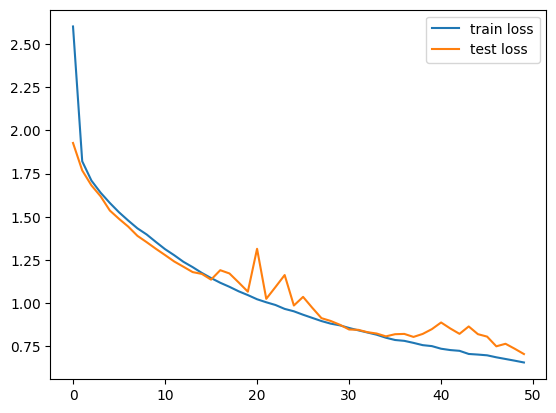

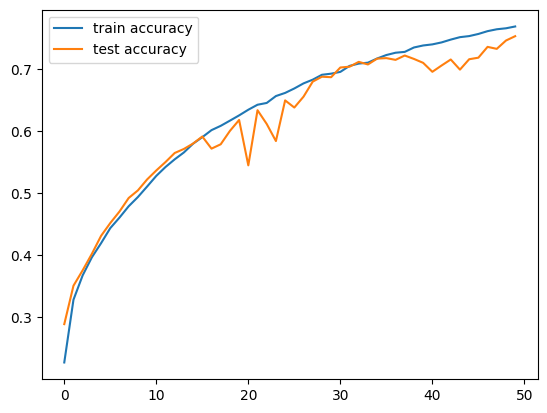

In [20]:
###########  Do not modify this cell ###########################
# ===============================================================

train_losses, train_accuracies, test_losses, test_accuracies = finetune()

plt.plot(train_losses, label='train loss')  # simply visualize the training loss
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='train accuracy')  # simply visualize the training loss
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()

**Explanation**

For the SIMCLR model, the following hyperparameters and data augmentation was used:

Hyperparameters:

batch_size = 128
projection_dim = 128
learning_rate =  0.001
momentum = 0.9
weight_decay = 0.0001
epochs = 3
optimizer = Optim.SGD
scheduler = StepLR

Data Augmentation:

RandomCrop(size=32, padding=4, padding_mode='reflect')
ColorJitter (brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
RandomHorizontalFlip
RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5)


For the LinLayer, the following hyperparameters and data augmentation was used:

Hyperparameters:

batch_size = 128
projection_dim = 128
learning_rate =  0.001
momentum = 0.9
weight_decay = 0.0001
epochs = 50
optimizer = Optim.SGD
scheduler = CosineAneahilingLR

Data Augmentation:

RandomCrop(size=32, padding=4, padding_mode='reflect')
ColorJitter (brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
RandomHorizontalFlip
RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5)


The final accuracy was found to be 75.24% and the loss was 0.7 for the test set.
